## Goal: 
- Write a 1D model of bedrock-alluvial river profile evolution. I want this model to:

> erode bedrock using stream power law

> deposit bedload after some distance

> abrade gravel downstream

> pick up gravel using eqb channel theory if bed is alluviated

> need a way to erode from bedrock and deposit in an alluvial layer

In [22]:
import numpy as np
import matplotlib.pyplot as plt

Steps/math leading to function described below:

1. $$\eta = \eta_b + H$$
> Says total elevation is equal to the elevation of the bedrock plus the thickness of alluvium sitting on the bedrock.

2. $$E = kqSe^{-H/H_*}$$
> This is an expression for stream power erosion of bedrock accounting for a partially covered bed.

3. $$q_s = cqS(1-e^{-H/H_*})$$
> Sediment transport (bedload sediment flux) is also going to be limited by the amount of sediment available on the bed.

4. $$\frac{\partial H}{\partial t} = E - \frac{\partial q_s}{\partial x}$$
> The change in thickness of alluvium through time as a given point on the bed is equal to the amount of alluvium that was generated at that point via erosion (alluvium has been generated and not yet moved) minus the change in bedload sediment flux across that point.

5. $$\frac{\partial \eta_b}{\partial t} = -E$$
> The change in bedrock elevation is equal to (minus) the amount of bedrock erosion.

6. $$ \eta = \eta_b + H \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = \frac{\partial \eta_b}{\partial t} + \frac{\partial H}{\partial t} \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = -E + E - \frac{\partial q_s}{\partial x}$$
> This is a little confusing to me. But I think it's saying that if we generate alluvium that is the same thickness as the amount of bed that is eroded, and so immediately add that to our alluvial layer, then the change in total elevation can just be expressed as a change in alluvial thickness because we've eliminated our bedrock river.

7. $$E_a = \beta q_s$$
> If we want to think about bed lowering by abrasion instead of stream power, then the amount of erosion due to abrasion will be the bedload sediment flux times some coefficient, $\beta$, that controls the volume of material abraded from the bed for each particle impact (as a fraction of impactor particle size).

>>7a. Is it fair to say $E_{\text total} = E_{sp} + E_a$, where $E_{sp}$ is bedrock lowering via stream power? Because that's the big assumption I'm making in the function below.

$$E_\text{total} = kqS + \beta q_s$$

>> If we want to represent multiple grain sizes, this is probably the place to do it, where $\beta$ for sand is small and $\beta$ for gravel is large. Can we add them, though? We first need to account for what fraction of $q_s$ is gravel and what fraction is sand.

>> Remember, $\beta$ has a saltation length embedded within it (it is essentially 1/saltation length). So $\beta$ should be small for sand because the saltation length is long, and large for gravel because the saltation length is small.

Idea: $$q_s = q_{ss} + q_{sg}$$

$$q_{ss} = 0.4q_s$$

$$q_{sg} = 0.6q_s$$
> We start the system with a pre-defined fraction of sand and gravel. Problem: If we stick with modulating alluvial thickness by simply multiplying by $\alpha$, this means that our hillslope contribution always has the same grain size distribution as our channel erosion. We need a way to update $q_{ss}$ and $q_{sg}$. 

$$q_{ss} += q_{ss}(1-\beta) + \alpha_{s}$$

8. $$E = E_{\text {total}} e^{-H/H_*} \hspace{1cm} \rightarrow \hspace{1cm} E = (kqS + \beta q_s) e^{-H/H_*}$$
> We now have an equation where both stream power and abrasion contribute to bed lowering. In adding these processes together, total lowering is still a function of the amount of bed exposed.

>> Thought: still not sure if it's "okay" to add these together - running with it for now, but it seems like you wind up calculating abrasion on blocks that are being plucked, so you end up putting more into the alluvial layer than what should actually result. Double-dipping, basically.

9. $$E = (kqS + \beta cqS(1 - e^{-H/H_*}))e^{-H/H_*}$$
> Here we're just substituting in equation (3) so that we can expression erosion in terms of discharge ($q$) and slope ($S$) instead of sediment flux ($q_s$). 

10. $$\frac{\partial \eta_b}{\partial t} = -(kqS + \beta cqS(1 - e^{-H/H_*}))e^{-H/H_*}$$
> This is now our change in elevation of bedrock if we assume lowering due to both stream power and abrasion (we're also ignoring allocyclic controls here, like landscape uplift or baselevel lowering). We got this by substituting equation (9) into equation (5).

We now have a more complete expression for $\eta_b$ in $\eta = \eta_b + H$, and it includes the bed being lowered by abrasion. What about for $H$? Remember, we're adding to $H$ (the thickness of our alluvial layer) everything that we just eroded ($E$, see above). Possibly not all of that material will enter bedload, though! Maybe some disappears as fines. It's also possible that the amount of alluvial bedload material will increase by more than simply what was eroded in the previous step, due to hillslope contributions. So we modulate $E$ with a coefficient called $\alpha$. At this point we also want to add a grain attrition term, which allows more alluvium to be picked up from the bed because we assume some amount of $q_s$ abrades to "fines" which are "lost" $\rightarrow$ allowing us to pick up a little more. So overall, this looks like:

11. $$\frac{\partial H}{\partial t} = \alpha E - \frac{\partial q_s}{\partial x} - \frac{q_s}{\lambda}$$
> This just summarizes the above paragraph.

12. $$\frac{\partial H}{\partial t} = \alpha e^{-H/H_*}(kqS + \beta q_s) -\frac{\partial q_s}{\partial x} - \frac{q_s}{\lambda}$$


$$\frac{\partial H}{\partial t} = -\frac{\partial q_s}{\partial x} + \alpha e^{-H/H_*}(kqS + \beta q_s) - \frac{q_s}{\lambda}$$

> Nothing new here, just substituting and rearranging.

13. $$\frac{\partial H}{\partial t} = -\frac{\partial q_s}{\partial x} + \alpha kqS e^{-H/H_*} + \beta q_s\left(\alpha e^{-H/H_*} -1\right)$$

> What we've done here is make a simplification from C&P 2009, which says that the attrition term we had added ($1/\lambda$) is basically the same thing as the abrasion coefficient. Both have units of $L^{-1}$, and represent an amount of material lost to abrasion. It's reasonable to assume that this value is the same both for bed abrasion and clast abrasion (attrition), because they are likely the same material (granitic bedrock?). So we substitute $\beta$ for $1/\lambda$ and rearrange.

14. $$\frac{\partial H}{\partial t} = -\frac{\partial cqS(1-e^{-H/H_*})}{\partial x} - \beta cqS(1-e^{-H/H_*})(1-\alpha e^{-H/H_*})$$
> This looks really ugly but all it's doing is making a substitution to write our equation in terms of $q$ and $S$ instead of $q_s$, and making a change in sign convention so that material lost to grain attrition will result in increased degradation of the alluvial layer.

15. $$\eta = \eta_b + H \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = \frac{\partial \eta_b}{\partial t} + \frac{\partial H}{\partial t} \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = - e^{-H/H_*}(kqS + \beta q_s) -\frac{\partial q_s}{\partial x} + \alpha kqS e^{-H/H_*} + \beta q_s\left(\alpha e^{-H/H_*} -1\right)$$

> Here I've written things in terms of $q_s$ for simplicity instead of $q$ and $S$. This says the total lowering is equal to the <b>amount of material eroded from the bed via both abrasion and stream power</b>, plus the change in bedload sed flux, plus the "extra" material entrained from the alluvial layer due to loss of fines in the system (all with $-$ signs to denote that these processes degrade the bed elevation).

Ways of representing multiple grain sizes (want 2-3, depending how you count them):
> 1. Fines, which disappear downstream (percentage of fines generated via bed abrasion is controlled by $\alpha$)
> 2. Sand ($\beta$ should be small)
> 3. Gravel ($\beta$ should be large)

In [23]:
# here, going to try to write a function that encapsulates this model idea.
# first try it as is, then try with variable grain sizes

In [52]:
# some constants
dx = 0.05
c = 1.0
k = 0.01
baselevel_rate = 0.01
num_steps = 1000000
Hstar = 1.0e-1
beta = 1
# alpha01 = 0.1
alpha1 = 2
# alpha10 = 10

In [53]:
# a function
def evolve_with_bedrock_and_abrasion(c, k, beta, alpha, dx=0.01, Hstar=1.0, baselevel_rate=0.01):
    x = np.arange(0.0, 1.0 + dx, dx)
    H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    etab = -H
    eta = etab + H
    ero = np.zeros(len(x))  # bedrock erosion rate
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / c  # time-step size

    for t in range(num_steps):
        eta[-1] -= baselevel_rate * dt  # lower baselevel
        etab[-1] = eta[-1]
        S = -np.diff(eta) / dx  # calc slope gradient
        efac = np.exp(-H / Hstar)
        
        # calc bed sed flux
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1]) # calc sediment flux
        
        # calc bedrock erosion from stream power
        ero_sp = efac[:-1] * (k * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab = efac[:-1] * (beta * qs[1:])
        
        # calc bedrock erosion rate from stream power and abrasion
        ero[:-1] = ero_sp + ero_ab
        
        # ero[:-1] = efac[:-1] * ((k * q[1:] * S) + (beta * qs[1:]))
        
        # calc change in bedrock elev
        etab[:-1] -= ero[:-1] * dt
        
        # H[:-1] += (ero[:-1] - (np.diff(qs) / dx)) * dt
        # H[:-1] += (ero[:-1] - (np.diff(qs) / dx) - (qs[1:] * beta * (1 - (alpha * efac[:-1])))) * dt
        
        # Add in alluvial thickness gained from stream power erosion + abrasion
        # H[:-1] += (-(np.diff(qs) / dx) - (qs[1:] * beta * (1 - (alpha * efac[:-1])))) * dt
        
        # grain attrition
        attrition = beta * qs[1:]
        
        # change in alluvial layer
        H[:-1] += (((alpha * efac[:-1])*((k * q[1:] * S) + (beta * qs[1:]))) - (np.diff(qs) / dx) - attrition) * dt
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]

    return eta, etab, H, qs, ero_sp, ero_ab, ero, attrition, x

In [54]:
eta, etab, H, qs, ero_sp, ero_ab, ero, attrition, x = evolve_with_bedrock_and_abrasion(c, k, beta, alpha1, dx, Hstar, baselevel_rate)

(0, 1)

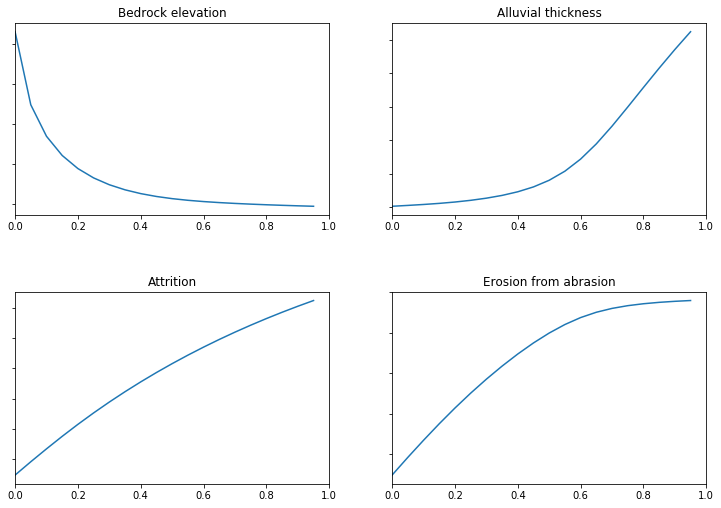

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))
# fig.tight_layout(pad=3.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

ax1.plot(x[:-1], etab[:-1])
ax1.set_title('Bedrock elevation')
ax1.yaxis.set_ticklabels([])
ax1.set_xlim(0, 1)

ax2.plot(x[:-1], H[:-1])
ax2.set_title('Alluvial thickness')
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0, 1)

ax3.plot(x[:-1], attrition)
ax3.set_title('Attrition')
ax3.yaxis.set_ticklabels([])
ax3.set_xlim(0, 1)

ax4.plot(x[:-1], ero_ab)
ax4.set_title('Erosion from abrasion')
ax4.yaxis.set_ticklabels([])
ax4.set_xlim(0, 1)

In [5]:
eta01, etab01, H01, qs01, ero01, x01 = evolve_with_bedrock_and_abrasion(c, k, beta, alpha01, dx, Hstar, baselevel_rate)
eta1, etab1, H1, qs1, ero1, x1 = evolve_with_bedrock_and_abrasion(c, k, beta, alpha1, dx, Hstar, baselevel_rate)
eta10, etab10, H10, qs10, ero10, x10 = evolve_with_bedrock_and_abrasion(c, k, beta, alpha10, dx, Hstar, baselevel_rate)

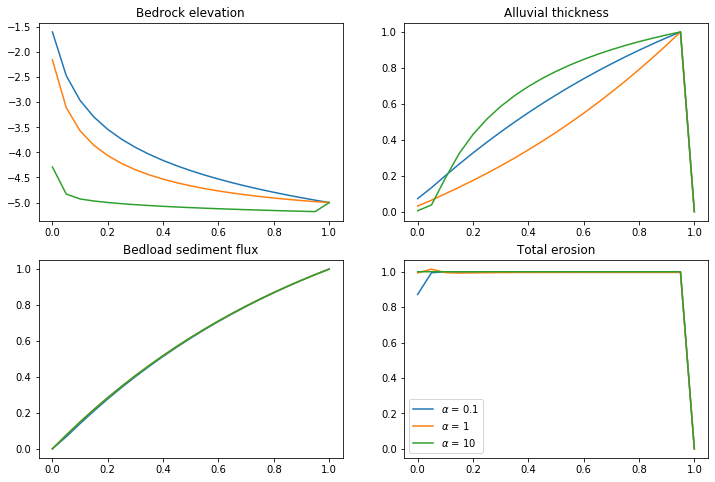

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))

ax1.plot(x01, etab01)# /(np.abs(np.max(eta01))))
ax1.plot(x1, etab1) #/(np.abs(np.max(eta1))))
ax1.plot(x10, etab10) #/(np.abs(np.max(eta10))))
ax1.set_title('Bedrock elevation')

ax2.plot(x01, H01/(np.abs(np.max(H01))))
ax2.plot(x1, H1/(np.abs(np.max(H1))))
ax2.plot(x10, H10/np.abs(np.max(H10)))
ax2.set_title('Alluvial thickness')

ax3.plot(x01, qs01/(np.abs(np.max(qs01))))
ax3.plot(x1, qs1/(np.abs(np.max(qs1))))
ax3.plot(x10, qs10/(np.abs(np.max(qs10))))
ax3.set_title('Bedload sediment flux')

ax4.plot(x01, ero01/(np.abs(np.max(ero01))), label = r'$\alpha$ = 0.1')
ax4.plot(x1, ero1/(np.abs(np.max(ero01))), label = r'$\alpha$ = 1')
ax4.plot(x10, ero10/(np.abs(np.max(ero10))), label = r'$\alpha$ = 10')
ax4.set_title('Total erosion')
ax4.legend()

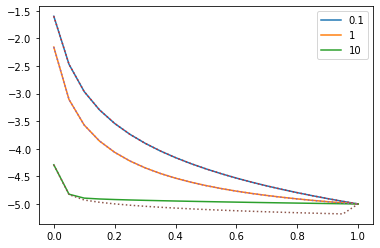

In [7]:
plt.plot(x01, eta01, label = '0.1')
plt.plot(x1, eta1, label = '1')
plt.plot(x10, eta10, label = '10')
plt.plot(x01, etab01, linestyle= ":")
plt.plot(x1, etab1, linestyle = ':')
plt.plot(x10, etab10, linestyle = ":")
plt.legend()
plt.show()

### Explanation of the above:

1. <b>Bedrock elevation</b>: As $\alpha$ increases, bed lowering decreases (i.e., there is less bedrock erosion). Why?
> Increasing $\alpha$ increases the thickness of the alluvial layer, so there is less bedrock exposure.

2. <b>Alluvial thickness</b>: When $\alpha$ = 1, the rate of alluvial thickening increases downstream. With $\alpha$ < 1 or $\alpha$ > 1, the rate of thickening decreases downstream. Why?
> When $\alpha$ = 1, we add to the alluvial layer exactly the amount of bedrock material eroded via either stream power or abrasion. This should mean that the rate of alluvial thickening scales with stream power erosion. 
> When $\alpha$ > 1, rate of alluvial thickening increases downstream

3. <b>Bedload sediment flux</b>: Alluvial thickness increases downstream. 
> Bedload sed flux should as well, as this is a function of the amount of bed covered by alluvium.

4. <b>Total erosion</b>: Total erosion stays constant because 

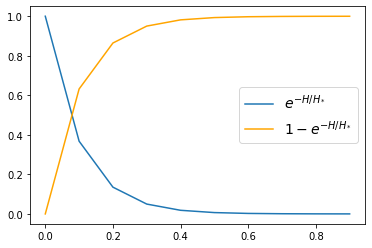

In [8]:
H_range = np.arange(0, 1, 0.1)
H_star = 0.1

y = np.exp(-H_range/H_star)
z = 1 - np.exp(-H_range/H_star)

plt.plot(H_range, y, label = '$e^{-H/H_*}$')
plt.plot(H_range, z, 'orange', label = '$1 - e^{-H/H_*}$')
plt.legend(fontsize = 14)
plt.show()

### Goal: non-dimensionalize these equations, come up with reasonable scales, simplify the parameter space, and plot changes to channel profile as we move through that space

1. Here are our basic equations. If we can make the terms on the righthand size dimensionless, then the solution will also be dimensionless.

> $$ \eta = \eta_b + H \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = \frac{\partial \eta_b}{\partial t} + \frac{\partial H}{\partial t}$$

2. We start by defining dimensionless versions of our major variables - vertical height (3 terms here - the total height $\eta$, the bedrock height $\eta_b$, and the alluvial thickness $H$), horizontal position ($x$), and time ($t$). We do this by dividing each of these variables by a scale that has the same dimension (either length or time) as the variable that we seek to non-dimensionalize. We'll worry about defining what the scales for horizontal position and time should be later. Our equations above have already have already introduced a handy scale for vertical height ($H^*$), so we use that for our vertical height scale here.

>$$\eta' = \frac{\eta}{H^*} \hspace{1cm} \rightarrow \hspace{1cm} \eta = \eta'H^*$$

>$$\eta_b' = \frac{\eta_b}{H^*} \hspace{1cm} \rightarrow \hspace{1cm} \eta_b = \eta_b'H^*$$

>$$H' = \frac{H}{H^*} \hspace{1cm} \rightarrow \hspace{1cm} H = H'H^*$$

>$$x' = \frac{x}{l} \hspace{1cm} \rightarrow \hspace{1cm} x = x'l$$

>$$t' = \frac{t}{T} \hspace{1cm} \rightarrow \hspace{1cm} t = t'T$$

3. We'll start by working on the bedrock bit. From above,

> $$\frac{\partial \eta_b}{\partial t} = - E_\text{total} = -(kqS + \beta q_s)$$

> For ease of LaTeX-ing, I've left off the "e-factor." It shouldn't make a difference in our non-dimensionalizing anyway because it's already dimensionless. I'll also drop the minus sign and just add it back in at the end, just so I don't have to keep typing out parentheses around everything.

4. We'll start with a few substitutions:

> $$q = rx$$
> Unit discharge $[L^2/T]$ is equal to a runoff rate multiplied by distance downstream

>$$S = \frac{\partial \eta}{\partial x}$$
> Slope is equal to the change in total elevation over a distance

>$$q_s = cqS \hspace{1cm} \rightarrow \hspace{1cm} q_s = crx\frac{\partial \eta}{\partial x}$$
> Bed sediment flux is equal to the discharge times slope times some factor that determines the fraction carried as bed sediment (function of grain size, roughness, etc). This equation should also be multiplied by the "e-factor," but again we'll skip that for now.

5. So now we have:
> $$\frac{\partial \eta_b}{\partial t} = krx\frac{\partial \eta}{\partial x} + \beta crx\frac{\partial \eta}{\partial x}$$

6. Now time for a bunch of substitutions. Any place where we see one of our major dimensional variables, we want to replace it with its non-dimensional form.

> $$\frac{\partial \eta_b'H^*}{\partial t'T} = krx'l\frac{\partial \eta'H^*}{\partial x'l} + \beta crx'l\frac{\partial \eta'H^*}{\partial x'l}$$

7. Now pull constants out of derivatives:

> $$\frac{H^*}{T} \frac{\partial \eta_b'}{\partial t'} = \frac{H^*}{l}krx'l\frac{\partial \eta'}{\partial x'} + \frac{H^*}{l}\beta crx'l\frac{\partial \eta'}{\partial x'}$$

8. Now rearrange to isolate the derivative on the lefthand side:

> $$\frac{\partial \eta_b'}{\partial t'} = \frac{T}{H^*}\frac{H^*}{l}krx'l\frac{\partial \eta'}{\partial x'} + \frac{T}{H^*}\frac{H^*}{l}\beta crx'l\frac{\partial \eta'}{\partial x'}$$

9. And cancel a bunch of stuff!

> $$\color{blue}{\frac{\partial \eta_b'}{\partial t'} = Tkrx'\frac{\partial \eta'}{\partial x'} + T\beta crx'\frac{\partial \eta'}{\partial x'}}$$

> Wahoo! We can check that these are all dimensionless terms now by recalling the dimensions of each variable and making sure they all cancel for both terms on the righthand side. Reminder: $k = [1/L]$ in our case.

> But, TRUCKERS, YOU ARE NOT DOWN YET. We still need to define T, our timescale. We'll do that in a bit, but first we'll repeat these steps for the other term in our governing equation: the alluvial thickness. 

10. Now we want to work on our alluvial component of our governing equation. As a reminder, that equation is:

> $$ \eta = \eta_b + H \hspace{1cm} \rightarrow \hspace{1cm} \frac{\partial \eta}{\partial t} = \frac{\partial \eta_b}{\partial t} + \frac{\partial H}{\partial t}$$

> We'll use all of the same scales defined in Step (2), but now we'll be focusing on $\frac{\partial H}{\partial t}$ instead of to $\frac{\partial \eta_b}{\partial t}$. So we're basically restarting at Step (3). 

11. We want to write the equation for our change in alluvial thickness in more complete terms. From above:

> $$\frac{\partial H}{\partial t} = \alpha E - \frac{\partial q_s}{\partial x} - \frac{q_s}{\lambda}$$

12. Now we're going to make quite a few substitutions.

> $$\frac{\partial H}{\partial t} = \alpha E - \frac{\partial q_s}{\partial x} - \beta q_s$$
> This first one replaces $1/\lambda$ with $\beta$ (reasoning stated above).

> $$\frac{\partial H}{\partial t} = \alpha E - \frac{\partial \left(crx\frac{\partial \eta}{\partial x}\right)}{\partial x} - \beta crx\frac{\partial \eta}{\partial x}$$
> Now we replace $q_s$ as we did in Step (4)

> $$\frac{\partial H}{\partial t} = \alpha E - crx\frac{\partial^2 \eta}{\partial x^2} - \beta crx\frac{\partial \eta}{\partial x}$$
> Pull constants out and simplify derivative

> $$\frac{\partial H}{\partial t} = \alpha krx\frac{\partial \eta}{\partial x} + \alpha \beta crx\frac{\partial \eta}{\partial x} - crx\frac{\partial^2 \eta}{\partial x^2} - \beta crx\frac{\partial \eta}{\partial x}$$
> Now we've replacted $E$ with our equation from Step (5) and distributed $\alpha$.

13. Now we're ready to replace all of our state variables with their dimensionless counterparts from Step (2)

> $$\frac{\partial H'H^*}{\partial t'T} = \alpha krx'l\frac{\partial \eta'H^*}{\partial x'l} + \alpha \beta crx'l\frac{\partial \eta'H^*}{\partial x'l} - crx'l\frac{\partial^2 \eta'H^*}{\partial (x'l)^2} - \beta crx'l\frac{\partial \eta'H^*}{\partial x'l}$$

14. Pull all constants out of derivative

> $$\frac{H^*}{T}\frac{\partial H'}{\partial t'} = \frac{H^*}{l}\alpha krx'l\frac{\partial \eta'}{\partial x'} + \frac{H^*}{l}\alpha \beta crx'l\frac{\partial \eta'}{\partial x'} - \frac{H^*}{l^2}crx'l\frac{\partial^2 \eta'}{\partial x'^2} - \frac{H^*}{l}\beta crx'l\frac{\partial \eta'}{\partial x'}$$

15. Now rearrange to isolate the derivative:

> $$\frac{\partial H'}{\partial t'} = \frac{T}{H^*}\frac{H^*}{l}\alpha krx'l\frac{\partial \eta'}{\partial x'} + \frac{T}{H^*}\frac{H^*}{l}\alpha \beta crx'l\frac{\partial \eta'}{\partial x'} - \frac{T}{H^*}\frac{H^*}{l^2}crx'l\frac{\partial^2 \eta'}{\partial x'^2} - \frac{T}{H^*}\frac{H^*}{l}\beta crx'l\frac{\partial \eta'}{\partial x'}$$

16. And cancel!

> $$\color{blue}{\frac{\partial H'}{\partial t'} = T\alpha krx'\frac{\partial \eta'}{\partial x'} + T\alpha \beta crx'\frac{\partial \eta'}{\partial x'} - \frac{T}{l}crx'\frac{\partial^2 \eta'}{\partial x'^2} - T\beta crx'\frac{\partial \eta'}{\partial x'}}$$

> Woo! We are now ready to define our time and horizontal length scales (all vertical scales have canceled here), and make those substitutions. This will allow us to ID the dimensionless groups that can act as a single "parameter" to tweak our system.

17. We can define the following scales:

> $$l = \frac{1}{\beta}$$
> This is chosen because a reasonable length scale is the distance of one saltation

> $$T = \frac{\beta H^{*2}}{cr}$$
> This is chosen because a reasonable timescale is the amount of time taken to transport a unit volume of sediment. We also don't want the timescale to depend on $k$, because that would mean that $k$ can never be 0.

18. Now plug these in everywhere they appear:

> $$\frac{\partial H'}{\partial t'} = \frac{\beta H^{*2}}{cr}\alpha krx'\frac{\partial \eta'}{\partial x'} + \frac{\beta H^{*2}}{cr}\alpha \beta crx'\frac{\partial \eta'}{\partial x'} - \frac{\frac{\beta H^{*2}}{cr}}{\frac{1}{\beta}}crx'\frac{\partial^2 \eta'}{\partial x'^2} - \frac{\beta H^{*2}}{cr}\beta crx'\frac{\partial \eta'}{\partial x'}$$

19. Simplify and cancel:

> $$\frac{\partial H'}{\partial t'} = \frac{\beta H^{*2}}{cr}\alpha krx'\frac{\partial \eta'}{\partial x'} + \frac{\beta H^{*2}}{cr}\alpha \beta crx'\frac{\partial \eta'}{\partial x'} - {\frac{\beta^2 H^{*2}}{cr}}crx'\frac{\partial^2 \eta'}{\partial x'^2} - \frac{\beta H^{*2}}{cr}\beta crx'\frac{\partial \eta'}{\partial x'}$$

> $$\color{green}{\frac{\partial H'}{\partial t'} = \frac{\beta H^{*2}\alpha k}{c}x'\frac{\partial \eta'}{\partial x'} + \beta^2 H^{*2}\alpha x'\frac{\partial \eta'}{\partial x'} - \beta^2 H^{*2}x'\frac{\partial^2 \eta'}{\partial x'^2} - \beta^2 H^{*2} x'\frac{\partial \eta'}{\partial x'}}$$

20. Last bit: now we want to plug the scales defined in Step (17) into the bedrock equation that we arrived at in Step (9).

> $$\frac{\partial \eta_b'}{\partial t'} = \frac{\beta H^{*2}}{cr}krx'\frac{\partial \eta'}{\partial x'} + \frac{\beta H^{*2}}{cr}\beta crx'\frac{\partial \eta'}{\partial x'}$$

21. Simplify and cancel!

> $$\color{green}{\frac{\partial \eta_b'}{\partial t'} = \frac{\beta H^{*2}k}{c}x'\frac{\partial \eta'}{\partial x'} + \beta^2 H^{*2}x'\frac{\partial \eta'}{\partial x'}}$$

By inspecting the two equations that we've arrived at (shown in $\color{green}{\text {green}}$), we see that the rate of elevation change in both bedrock and alluvial thickness depends on several dimensionless groups that include the parameters $\beta, H^*, \alpha, k, \text {and}, c$.

In the bedrock equation, these groups are:
> $$\frac{\beta H^{*2}k}{c}$$

> $$\beta^2 H^{*2}$$

Because these groups are not the same for each term, it may be difficult to seperate the effect of changing any of the parameters that constitute the group. For example, if we had only one dimensionless group for both terms of the bedrock equation, then we could easily say, "Doubling $\beta$ should have the exact same effect on tbe system as doubling $k$." But because doubling $k$ would actually have no effect on the second term of the bedrock equation, this gets tricky. But we'll just plow ahead.

In the alluvial thickness equation, these groups are:
> $$\frac{\beta H^{*2}\alpha k}{c}$$

> $$\beta^2 H^{*2}\alpha$$

> $$\beta^2 H^{*2}$$

Here we have the same "problem" - however, interpretation may be helped by the fact that we at least know what each term of these equations represents. For example, in the alluvial thickness equation, $\beta$ is squared everywhere except for on the first term. We know that first term represents the amount of sediment that is contributed to alluvial thickness via stream power erosion of the bedrock, so we can say, "Doubling $\beta$ doubles the contribution of sediment from stream power erosion of bedrock." $\beta$ is squared everywhere else, so we can say, for example (referencing the second term in our equation), "Doubling $\beta$ quadruples the contribution of sediment from bedrock abrasion." 

In [9]:
# Now we want to take what we've just done and write it into a (dimensionless!) model

In [10]:
# start by defining variables

dx = 0.05
c = 1.0
k = 0.01
baselevel_rate = 0.01
num_steps = 1000000
Hstar = 1.0e-1
beta = 1
alpha = 1
r = 0.001

In [27]:
# a function

def dimensionless_bedrock_alluvial_model(c, k, beta, alpha, r, Hstar, dx=0.01, baselevel_rate=0.01):
    x = np.arange(0.0, 1.0 + dx, dx)
    H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    etab = -H
    eta = etab + H
    ero = np.zeros(len(x))  # bedrock erosion rate
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / c  # time-step size
    
    # dimensionless scales
    l = 1/beta
    T = (beta * Hstar**2)/(c * r)
    
    eta_prime = eta/Hstar
    etab_prime = etab/Hstar
    H_prime = H/Hstar
    x_prime = x/l
    t_prime = (num_steps * dt)/T
    
    q = x_prime * l * r # discharge
    
    # dimensionless groups
    group1 = (beta * Hstar**2 * k)/c
    group2 = beta**2 * Hstar**2
    group3 = (beta * Hstar**2 * alpha * k)/c
    group4 = beta**2 * Hstar**2 * alpha
    group5 = beta**2 * Hstar**2

    for t in range(num_steps):
        eta_prime[-1] -= baselevel_rate * dt  # lower baselevel
        etab_prime[-1] = eta_prime[-1]
        S = -np.diff(eta_prime) / dx  # calc slope gradient
        efac = np.exp(-H_prime)
        
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1]) # calc sediment flux
        
        ero[:-1] = efac[:-1] * ((group1 * x_prime[:-1] * S) + (group2 * x_prime[0:-1] * S)) # bedrock erosion from SP & abrasion
        etab_prime[:-1] -= ero[:-1] * dt # calc change in bedrock elev
        
        # Add in alluvial thickness gained from stream power erosion + abrasion
        H_prime[:-1] += (efac[:-1] * ((group3 * x_prime[:-1] * S) + (group4 * x_prime[:-1] * S))) - ((efac[:-1] - 1) * ((group5 * x_prime[:-1] * S**2) - (group5 * x_prime[:-1] * S)))
        
        eta_prime[:-1] = etab_prime[:-1] + H_prime[:-1]  # update bed elevation

    return eta_prime, etab_prime, H_prime, qs, ero, x, x_prime

In [28]:
eta_prime, etab_prime, H_prime, qs, ero, x, x_prime = dimensionless_bedrock_alluvial_model(c, k, beta, alpha, r, Hstar)

In [32]:
Hstar2 = Hstar*2
eta_prime2, etab_prime2, H_prime2, qs2, ero2, x2, x_prime2 = dimensionless_bedrock_alluvial_model(c, k, beta, alpha, r, Hstar2)

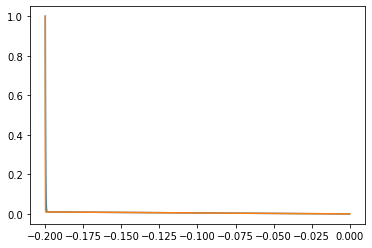

In [34]:
plt.plot(eta_prime, x)
plt.plot(eta_prime2, x)
plt.show()